In [2]:
import os
import math

import torch
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from tqdm import tqdm
from PIL import Image, ImageDraw

from scorefield.models.ddpm.denoising_diffusion import Unet
from scorefield.models.heat.heat_diffusion import HeatDiffusion_Revised
from scorefield.models.rrt.rrt import RRTStar
from scorefield.utils.rl_utils import load_config
from scorefield.utils.utils import (
    gen_goals, overlay_goal, overlay_multiple, combine_objects, overlay_images,gen_agents,
    overlay_goal_agent, overlay_goals_agent, log_num_check,
    draw_obstacles_pil, convert_to_obstacle_masks,
    randgen_obstacle_masks, draw_obstacles_pixel,
    vector_field, clip_vectors
)
from scorefield.utils.diffusion_utils import bilinear_interpolate, bilinear_interpolate_samples

import matplotlib.pyplot as plt
import itertools
from typing import Optional

from matplotlib import cm


# Args
config_dir = "./scorefield/configs/heat_diffusion.yaml"
args = load_config(config_dir)
device = args['device']

bg = Image.open('assets/toy_exp/background0.png')
wastes = []
wastes.append(Image.open('assets/toy_exp/waste0.png'))
# wastes.append(Image.open('assets/toy_exp/waste4.png'))
# wastes.append(Image.open('assets/toy_exp/waste5.png'))


img_size = args['image_size']
goal_bounds = args['goal_bounds']
goal_num = len(wastes)
agent_bounds = args['agent_bounds']
obstacle_pos = args['obstacles']

model_path = os.path.join(args['log_path'], args['model_path'])

u0 = args['u0']
min_heat_step = args['min_heat_step']
max_heat_step = args['max_heat_step']
noise_steps = args['noise_steps']
sample_num = args['sample_num']
time_type = args['time_type']

train_lr = args['train_lr']
batch_size = noise_steps #args['batch_size']
seed = args['seed']

class Unet2D(Unet):
    def __init__(
        self, 
        dim, 
        out_dim, 
        dim_mults=(1, 2, 4, 8),
    ):
        super().__init__(dim=dim, out_dim=out_dim, dim_mults=dim_mults)

    def forward(self, obs, t, x_t:Optional[torch.Tensor]=None):
        score_map = super().forward(obs, t)
        if x_t is not None:
            score = bilinear_interpolate_samples(score_map, x_t)    # output: (B,2)
            return score, score_map.permute(0,2,3,1)
        else:
            return score_map.permute(0, 2, 3, 1)
    
model = Unet2D(
    dim=img_size,
    out_dim = 2,
    dim_mults = (1, 2, 4, 8),
).to(device)

diffusion = HeatDiffusion_Revised(
    image_size=img_size,
    u0 = u0,
    noise_steps=noise_steps,
    min_heat_step=min_heat_step,
    max_heat_step=max_heat_step,
    time_type=time_type,
    device=device,
)

model.load_state_dict(torch.load(f'./runs/heat/model_params.pt'))

def remove_collisions(states, obstacle):
    """
        states: [B, N ,2]
        obstacle: [B, img_sz, img_sz]
    """
    mapped_states = ((states + 1)*31.5).long()
    
    overlap_mask = []
    for b in range(states.size(0)):
        batch_overlap = [not obstacle[b, y, x] for y, x in mapped_states[b]]
        overlap_mask.append(batch_overlap)
    overlap_mask = torch.tensor(overlap_mask, dtype=torch.bool)

    # Use overlap_mask to filter out the states
    filtered_states_list = [batch[mask] for batch, mask in zip(states, overlap_mask)]
    
    # Find the maximum length after filtering for padding
    max_len = max([fs.size(0) for fs in filtered_states_list])

    # Pad each batch tensor to max_len
    padded_states = [torch.cat([fs, torch.zeros(max_len - fs.size(0), 2).to(states.device)], dim=0) 
                     for fs in filtered_states_list]

    # Stack all padded tensors
    filtered_states_tensor = torch.stack(padded_states, dim=0)

    return filtered_states_tensor

def count_states(states, goals, threshold=0.1563):
    B, N, _ = states.shape
    _, M, _ = goals.shape
    
    expanded_states = states.unsqueeze(2).expand(-1, -1, M, -1)
    expanded_goals = goals.unsqueeze(1).expand(-1, N, -1, -1)
    
    differences = expanded_states - expanded_goals
    squared_dist = torch.sum(differences**2, dim=-1)
    
    close_mask = squared_dist < threshold**2

    # Use torch.sum to count for each goal, then convert to a Python integer.
    counts = [int(close_mask[..., i].sum().item()) for i in range(M)]
    
    return counts

dt:tensor([   50,   128,   288,   578,  1058,  1922,  3200,  5408,  8978, 14450],
       device='cuda:0')
heat kernel std:tensor([ 5.,  8., 12., 17., 23., 31., 32., 32., 32., 32.], device='cuda:0')


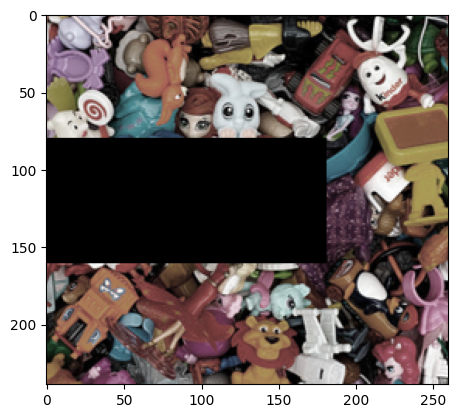

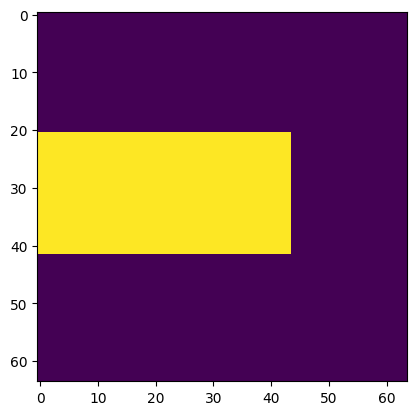

In [3]:
# Evaluation pre-setting

background = draw_obstacles_pil(bg, obstacle_pos)
obstacle_mask = convert_to_obstacle_masks(noise_steps, background[0].size, img_size, obstacle_pos)
# obstacle_mask = randgen_obstacle_masks(1, img_size, seed=seed)
# background = draw_obstacles_pixel(bg, obstacle_mask)
plt.imshow(background[0])
plt.show()

obstacle_masks = obstacle_mask[0].unsqueeze(0)

plt.imshow(obstacle_masks[0].cpu().numpy())
plt.show()


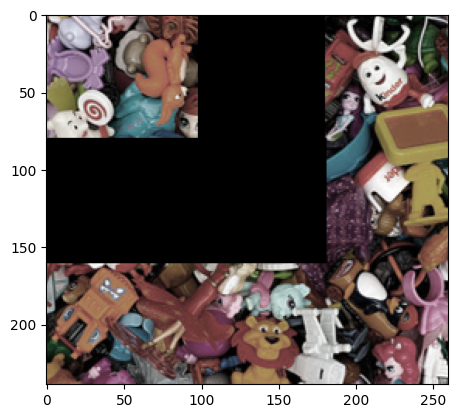

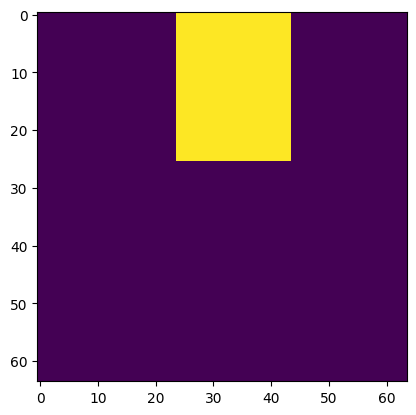

In [4]:
# Evaluation pre-setting2 : Cover one of the goals for reachable goal estimation
# obstacle_added = convert_to_obstacle_masks(1, background[0].size, img_size, [[100,150,180,260]])
obstacle_added = convert_to_obstacle_masks(1, background[0].size, img_size, [[100,0,180,100]])
background2 = draw_obstacles_pixel(background[0].copy(), obstacle_added)
plt.imshow(background2[0])
plt.show()
plt.imshow(obstacle_added[0].cpu().numpy())
plt.show()

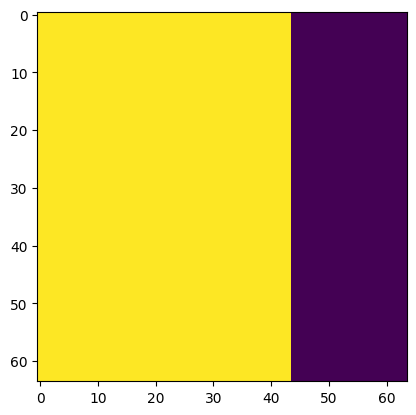

In [5]:
obstacle_added2 = convert_to_obstacle_masks(1, background2[0].size, img_size, [[0,0,180,260]])
# obstacle_added3 = convert_to_obstacle_masks(1, background2[0].size, img_size, [[0,0,120,100]])
plt.imshow(obstacle_added2[0].cpu().numpy())
plt.show()

10it [00:26,  2.66s/it]


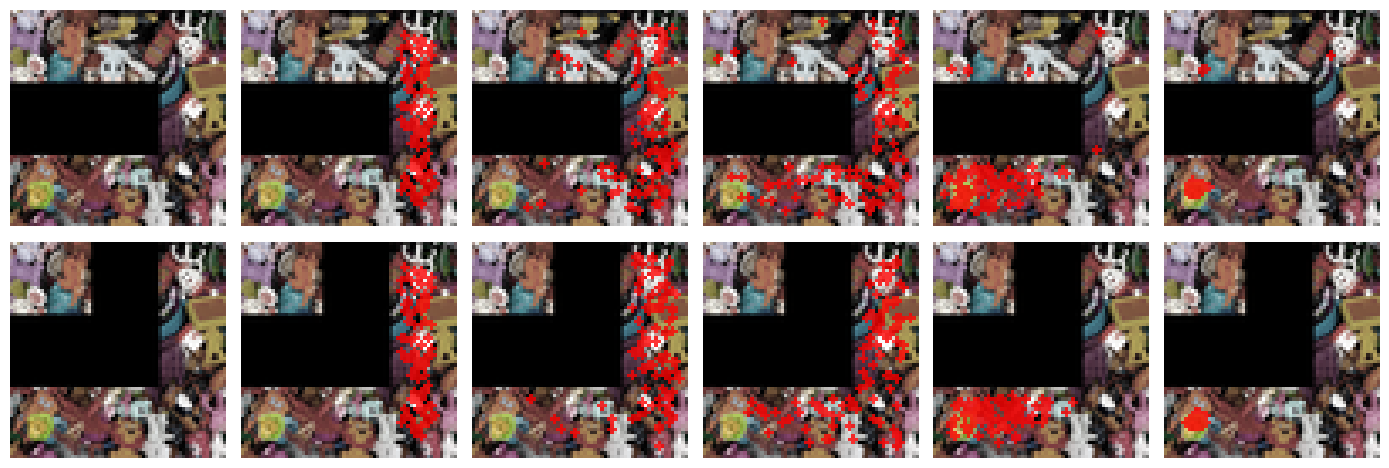

In [12]:
# Evaluation - Single goal
initial_states = 100

lan_t = 100  # 4
epsilon = .001
k1 = .7
k2 = .3

goals = torch.tensor([[[0.7, -0.7]]], device=device, dtype=torch.float32)
obs_T = overlay_goal(background, img_size, wastes, goals)
obs_T2 = overlay_goal(background2, img_size, wastes, goals)

c = 10

T = diffusion.noise_steps
step_size = 2 # int(T / c)
dot_size = 1.

fig, axs = plt.subplots(2, c//step_size+1, figsize=(14,5))

model.eval()
ims = []
ims2 = []

axs[0,0].axis('off')
axs[0,0].imshow(obs_T[0].permute(1,2,0).cpu().numpy())
axs[1,0].axis('off')
axs[1,0].imshow(obs_T2[0].permute(1,2,0).cpu().numpy())

successes = []
# for ex in range(100):
with torch.no_grad():
    # x_T = torch.tensor([[[-0.8, 0.8]]], device=device, dtype=torch.float32)
    x_T = gen_agents(goal_bounds, (initial_states,1), img_size, obstacles=obstacle_added2, seed=seed)
    x = x_T.clone()
    x2 = x_T.clone()

    k=1
    for i in tqdm(reversed(range(1, T+1)), position=0):
        if i == T or i==int(T*0.7) or i==int(T*0.5) or i==int(T*0.3):
            backg = background.copy()
            backg2 = background2.copy()

            img_sample = overlay_goal_agent(backg, wastes, goals.cpu(), x.cpu(), circle_rad=dot_size)
            img_sample2 = overlay_goal_agent(backg2, wastes, goals.cpu(), x2.cpu(), circle_rad=dot_size)

            for s in range(len(img_sample)):
                axs[0,k].imshow(img_sample[s])
                # axs[0,k].set_title(f't = {i}', fontsize=10)
                axs[0,k].axis('off')
                axs[1,k].imshow(img_sample2[s])
                axs[1,k].axis('off')
                k += 1

        t = (torch.ones(1) * i).long().to(device)

        alpha = epsilon * (diffusion.std[i-1] / diffusion.std[-1])**2

        for _ in range(lan_t):
            x_prev = x.clone()
            score, _ = model(obs_T, t, x)

            x = x_prev + (img_size / (2*diffusion.std[i-1])) * score * alpha**k1 + torch.randn_like(x) * alpha**((k1+k2)/2)

            if not (x[...,:].abs() <=0.99).all():        
                x = x_prev
            bkg = background.copy()
            im = overlay_goal_agent(bkg, wastes, goals.cpu(), x.cpu(), circle_rad=dot_size)
            ims.append(im)
        x = remove_collisions(x, obstacle_masks)

        for _ in range(lan_t):
            x_prev2 = x2.clone()
            score2, _ = model(obs_T2, t, x2)

            x2 = x_prev2 + (img_size / (2*diffusion.std[i-1])) * score2 * alpha**k1 + torch.randn_like(x2) * alpha**((k1+k2)/2)

            if not (x2[...,:].abs() <=0.99).all():        
                x2 = x_prev2

            bkg2 = background2.copy()
            im2 = overlay_goal_agent(bkg2, wastes, goals.cpu(), x2.cpu(), circle_rad=dot_size)
            ims2.append(im2)
        x2 = remove_collisions(x2, obstacle_masks|obstacle_added)           


    backg = background.copy()
    backg2 = background2.copy()
    img_sample = overlay_goal_agent(backg, wastes, goals.cpu(), x.cpu(), circle_rad=dot_size)
    img_sample2 = overlay_goal_agent(backg2, wastes, goals.cpu(), x2.cpu(), circle_rad=dot_size)
    for s in range(len(img_sample)):
        axs[0,-1].imshow(img_sample[s])
        # axs[0,-1].set_title(f't = {1}', fontsize=10)
        axs[0,-1].axis('off')
        axs[1,-1].imshow(img_sample2[s])
        axs[1,-1].axis('off')

    bkg = background.copy()
    bkg2 = background2.copy()
    im = overlay_goal_agent(bkg, wastes, goals.cpu(), x.cpu(), circle_rad=dot_size)
    im2 = overlay_goal_agent(bkg2, wastes, goals.cpu(), x2.cpu(), circle_rad=dot_size)
    ims.append(im)   
    ims2.append(im2)

successes.append(sum(count_states(x, goals)))

# final_states = x.cpu().numpy()
# np.save(f'./results/heat/single_goal/states_{ex}.npy', final_states)

    
plt.tight_layout()


In [13]:
print("Case 1 : ")
print(f"initial x : {initial_states}, final x : {count_states(x, goals)}")
print("Case 2 : ")
print(f"initial x : {initial_states}, final x : {count_states(x2, goals)}")

final_states = x.cpu().numpy()
final_states2 = x2.cpu().numpy()
# np.save('./results/heat/state.npy', final_states)
# np.save('./results/heat/state2.npy', final_states2)

# np.save('./results/heat/eval.npy', ims)
# np.save('./results/heat/eval2.npy', ims2)

In [5]:
baseline = Unet2D(
    dim=img_size,
    out_dim = 2,
    dim_mults = (1, 2, 4, 8),
).to(device)

baseline.load_state_dict(torch.load(f'./runs/baselines/BC/model_params.pt'))

<All keys matched successfully>

In [ ]:
# Benchmark - BC
initial_states = 100

goals = torch.tensor([[[0.7,-0.7],[-0.7,-0.7]]], device=device, dtype=torch.float32)
obs_T = overlay_goal(background, img_size, wastes, goals)
obs_T2 = overlay_goal(background2, img_size, wastes, goals)

c = 10

T = diffusion.noise_steps
step_size = 2 # int(T / c)
dot_size = 1.

fig, axs = plt.subplots(2, c//step_size, figsize=(12,5))

model.eval()
baseline.eval()
ims = []
ims2 = []
bases = []

successes = []
successes2 = []
for ex in range(100):
    with torch.no_grad():
        x_T = gen_agents(goal_bounds, (initial_states,1), img_size, obstacles=obstacle_added2, seed=seed)
        base_x = x_T.clone()
        base_x2 = x_T.clone()

        for i in tqdm(reversed(range(1, T+1)), position=0):
            if (T-i+1) % step_size == 0:
                k = (T-i) // step_size
                backg = background.copy()
                backg2 = background2.copy()

                # img_sample = overlay_goal_agent(backg, wastes, goals.cpu(), x.cpu(), dot_size)
                base_sample = overlay_goal_agent(backg, wastes, goals.cpu(), base_x.cpu(), circle_rad=dot_size)
                base_sample2 = overlay_goal_agent(backg2, wastes, goals.cpu(), base_x2.cpu(), circle_rad=dot_size)
                for s in range(len(base_sample)):
                    axs[0,k].imshow(base_sample[s])
                    # axs[0,k].set_title(f't = {T-i+1}')
                    axs[0,k].axis('off')
                    axs[1,k].imshow(base_sample2[s])
                    # axs[1,k].set_title(f't = {T-i+1}')
                    axs[1,k].axis('off')

            base_t = torch.ones(1).long().to(device)

            for _ in range(4):
                base_x_prev = base_x.clone()
                delta,_  = baseline(obs_T, base_t, base_x)

                base_x = base_x_prev + delta

                base_x = remove_collisions(base_x, obstacle_masks)

                bkg = background.copy()
                im = overlay_goal_agent(bkg, wastes, goals.cpu(), base_x.cpu(), circle_rad=dot_size)
                ims.append(im)   

            for _ in range(4):
                base_x_prev2 = base_x2.clone()
                delta2,_  = baseline(obs_T2, base_t, base_x2)

                base_x2 = base_x_prev2 + delta2

                base_x2 = remove_collisions(base_x2, obstacle_masks|obstacle_added)

                bkg2 = background2.copy()
                im2 = overlay_goal_agent(bkg2, wastes, goals.cpu(), base_x2.cpu(), circle_rad=dot_size)
                ims2.append(im2)


        backg = background.copy()
        backg2 = background2.copy()
        # img_sample = overlay_goal_agent(backg, wastes, goals.cpu(),x.cpu(), dot_size)
        base_sample = overlay_goal_agent(backg, wastes, goals.cpu(), base_x.cpu(), circle_rad=dot_size)
        base_sample2 = overlay_goal_agent(backg2, wastes, goals.cpu(), base_x2.cpu(), circle_rad=dot_size)
        for s in range(len(base_sample)):
            axs[0,-1].imshow(base_sample[s])
            # axs[0,-1].set_title(f't = {T}')
            axs[0,-1].axis('off')    
            axs[1,-1].imshow(base_sample2[s])
            # axs[1,-1].set_title(f't = {T}')
            axs[1,-1].axis('off')

        bkg = background.copy()
        bkg2 = background2.copy()
        im = overlay_goal_agent(bkg, wastes, goals.cpu(), base_x.cpu(), circle_rad=dot_size)
        im2 = overlay_goal_agent(bkg2, wastes, goals.cpu(), base_x2.cpu(), circle_rad=dot_size)
        ims.append(im)   
        ims2.append(im2)
        
    successes.append(sum(count_states(base_x, goals)))
    successes2.append(sum(count_states(base_x2, goals)))
    final_states = base_x.cpu().numpy()
    final_states2 = base_x2.cpu().numpy()
    np.save(f'./results/baselines/BC/multi_goal/states_{ex}.npy', final_states)
    np.save(f'./results/baselines/BC/unreach_goal/states_{ex}.npy', final_states2)

plt.tight_layout()


In [9]:
final_states = base_x.cpu().numpy()
np.save('./results/baselines/BC/multi_state.npy', final_states)

In [17]:
print("Case 1 : ")
print(f"initial x : {initial_states}, final x : {count_states(base_x, goals)}")
print("Case 2 : ")
print(f"initial x : {initial_states}, final x : {count_states(base_x2, goals)}")

final_states = base_x.cpu().numpy()
final_states2 = base_x2.cpu().numpy()
np.save('./results/baselines/BC/multi_state.npy', final_states)
np.save('./results/baselines/unreach_state.npy', final_states2)

# np.save('./results/baselines/eval.npy', ims)
# np.save('./results/baselines/eval2.npy', ims2)

Case 1 : 
initial x : 100, final x : [0, 0]
Case 2 : 
initial x : 100, final x : [0, 0]


In [6]:
baseline2 = Unet2D(
    dim=img_size,
    out_dim = 2,
    dim_mults = (1, 2, 4, 8),
).to(device)

baseline2.load_state_dict(torch.load(f'./runs/baselines/Gaussian/model_params.pt'))

gaus_config_dir = "./scorefield/configs/gaussian.yaml"
args = load_config(gaus_config_dir)
diffuse_t = args['diffuse_t']

rrt = RRTStar(
    image_size=img_size,
    time_steps=10,
    delta_dist=0.08,
    radius=0.02,
    random_seed=seed,
)

1it [00:04,  4.51s/it]


KeyboardInterrupt: 

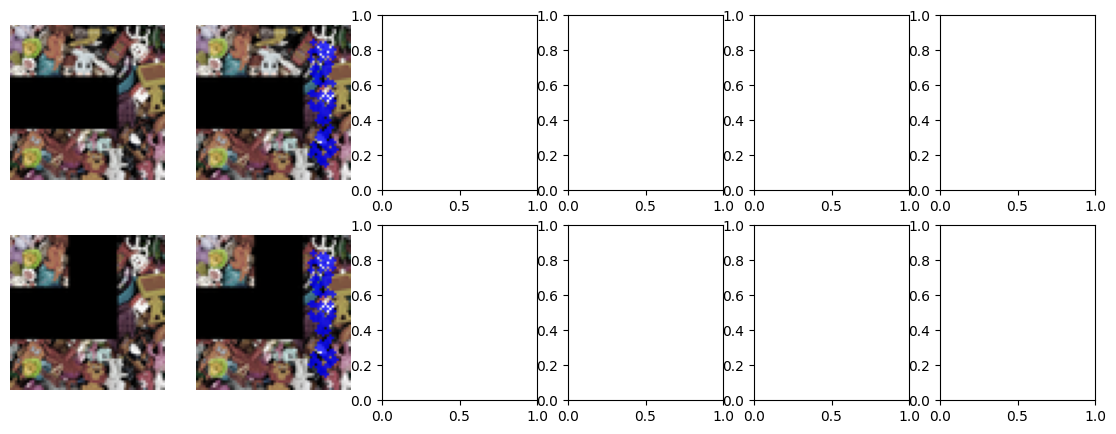

In [15]:
# Benchmark - Gaussian
initial_states = 100

lan_t = 100  # 4
epsilon = .01

goals = torch.tensor([[[0.7, -0.7], [-0.7,-0.7]]], device=device, dtype=torch.float32)
obs_T = overlay_goal(background, img_size, wastes, goals)
obs_T2 = overlay_goal(background2, img_size, wastes, goals)

c = 10

T = diffusion.noise_steps
step_size = 2 # int(T / c)
dot_size = 1.

fig, axs = plt.subplots(2, c//step_size+1, figsize=(14,5))

model.eval()
ims = []
ims2 = []

axs[0,0].axis('off')
axs[0,0].imshow(obs_T[0].permute(1,2,0).cpu().numpy())
axs[1,0].axis('off')
axs[1,0].imshow(obs_T2[0].permute(1,2,0).cpu().numpy())

successes = []
successes2 = []
for ex in range(100):
    with torch.no_grad():
        # Sample goal

        x_T = gen_agents(goal_bounds, (initial_states,1), img_size, obstacles=obstacle_added2, seed=seed)
        x = x_T.clone()
        x2 = x_T.clone()

        k=1
        for i in tqdm(reversed(range(1, T+1)), position=0):
            if i == T or i==int(T*0.7) or i==int(T*0.5) or i==int(T*0.3):
                backg = background.copy()
                backg2 = background2.copy()

                img_sample = overlay_goal_agent(backg, wastes, goals.cpu(), x.cpu(), col='blue', circle_rad=dot_size)
                img_sample2 = overlay_goal_agent(backg2, wastes, goals.cpu(), x2.cpu(), col='blue', circle_rad=dot_size)

                for s in range(len(img_sample)):
                    axs[0,k].imshow(img_sample[s])
                    axs[0,k].axis('off')
                    axs[1,k].imshow(img_sample2[s])
                    axs[1,k].axis('off')
                    k += 1

            t = (torch.ones(1) * i).long().to(device)

            for _ in range(lan_t):
                x_prev = x.clone()
                score, _ = baseline2(obs_T, t, x)

                x = x_prev + score/(2*diffuse_t) * epsilon + torch.randn_like(x_prev) * math.sqrt(epsilon) * 0.1

                if not (x[...,:].abs() <=0.99).all():        
                    x = x_prev
                bkg = background.copy()
                im = overlay_goal_agent(bkg, wastes, goals.cpu(), x.cpu(), col='blue', circle_rad=dot_size)
                ims.append(im)

            for _ in range(lan_t):
                x_prev2 = x2.clone()
                score2, _ = baseline2(obs_T2, t, x2)

                x2 = x_prev2 + score2/(2*diffuse_t) * epsilon + torch.randn_like(x_prev2) * math.sqrt(epsilon) * 0.1

                if not (x2[...,:].abs() <=0.99).all():        
                    x2 = x_prev2

                bkg2 = background2.copy()
                im2 = overlay_goal_agent(bkg2, wastes, goals.cpu(), x2.cpu(), col='blue', circle_rad=dot_size)
                ims2.append(im2)         


        backg = background.copy()
        backg2 = background2.copy()
        img_sample = overlay_goal_agent(backg, wastes, goals.cpu(), x.cpu(), col='blue', circle_rad=dot_size)
        img_sample2 = overlay_goal_agent(backg2, wastes, goals.cpu(), x2.cpu(), col='blue', circle_rad=dot_size)
        for s in range(len(img_sample)):
            axs[0,-1].imshow(img_sample[s])
            axs[0,-1].axis('off')
            axs[1,-1].imshow(img_sample2[s])
            axs[1,-1].axis('off')

        bkg = background.copy()
        bkg2 = background2.copy()
        im = overlay_goal_agent(bkg, wastes, goals.cpu(), x.cpu(), col='blue', circle_rad=dot_size)
        im2 = overlay_goal_agent(bkg2, wastes, goals.cpu(), x2.cpu(), col='blue', circle_rad=dot_size)
        ims.append(im)   
        ims2.append(im2)
        
    # RRT*
    paths1=[]
    col1 = 0
    for z in range(initial_states):
        path1, _ = rrt.plan(starts=x_T[0][z].reshape(1,1,2), goals=x[0][z].reshape(1,1,2), obstacle_masks=obstacle_masks)
        path1_removed = remove_collisions(torch.tensor(path1[0], device=device), obstacle_masks)
        if len(path1[0][0]) != path1_removed.shape[1]:
            col1 += 1
            continue
        paths1.append([path1_removed[0][-1]])
    flattened_paths1 = [item[0] for item in paths1]
    paths_final1 = torch.stack(flattened_paths1).unsqueeze(0)
    
    paths2 = []
    col2 = 0
    for zz in range(initial_states):
        path2, _ = rrt.plan(starts=x_T[0][zz].reshape(1,1,2), goals=x2[0][zz].reshape(1,1,2), obstacle_masks=obstacle_masks)
        path2_removed = remove_collisions(torch.tensor(path2[0], device=device), obstacle=obstacle_masks|obstacle_added)
        if len(path2[0][0]) != path2_removed.shape[1]:
            col2 += 1
            continue
        paths2.append([path2_removed[0][-1]])
    flattened_paths2 = [item[0] for item in paths2]
    paths_final2 = torch.stack(flattened_paths2).unsqueeze(0)
        
    successes.append(sum(count_states(paths_final1, goals)))
    successes2.append(sum(count_states(paths_final2, goals)))
    final_states = paths_final1[0].cpu().numpy()
    final_states2 = paths_final2[0].cpu().numpy()
    np.save(f'./results/baselines/Gaussian/multi_goal/state_{ex}.npy', final_states)
    np.save(f'./results/baselines/Gaussian/unreach_goal/states_{ex}.npy', final_states2)

    
plt.tight_layout()


In [11]:
print(min(successes), max(successes))

93 100


In [14]:
import numpy as np
from scipy import stats

# Compute the sample mean and standard error of the mean
mean = np.mean(successes)
sem = stats.sem(successes)

# Compute the 95% confidence interval
confidence_level = 0.95
degrees_freedom = len(successes) - 1
lower_bound, upper_bound = stats.t.interval(confidence_level, degrees_freedom, mean, sem)

# Compute the Margin of Error (MOE)
moe = (upper_bound - lower_bound) / 2

print(f"95% Confidence Interval: {mean:.2f} ± {moe:.2f}")

95% Confidence Interval: 96.47 ± 0.28


In [12]:
# RRT*
paths1=[]
col1 = 0
for z in range(initial_states):
    path1, _ = rrt.plan(starts=x_T[0][z].reshape(1,1,2), goals=x[0][z].reshape(1,1,2), obstacle_masks=obstacle_masks)
    path1_removed = remove_collisions(torch.tensor(path1[0], device=device), obstacle_masks)
    if len(path1[0][0]) != path1_removed.shape[1]:
        col1 += 1
        print(f"Collision: {col1}")
        continue
    paths1.append([path1_removed[0][-1]])
flattened_paths1 = [item[0] for item in paths1]
paths_final1 = torch.stack(flattened_paths1).unsqueeze(0)
print("Case 1 : ")
print(f"initial x : {initial_states}, final x : {count_states(paths_final1, goals)}")

paths2 = []
col2 = 0
for zz in range(initial_states):
    path2, _ = rrt.plan(starts=x_T[0][zz].reshape(1,1,2), goals=x2[0][zz].reshape(1,1,2), obstacle_masks=obstacle_masks)
    path2_removed = remove_collisions(torch.tensor(path2[0], device=device), obstacle=obstacle_masks|obstacle_added)
    if len(path2[0][0]) != path2_removed.shape[1]:
        col2 += 1
#         print(f"Collision: {col2}")
        continue
    paths2.append([path2_removed[0][-1]])
flattened_paths2 = [item[0] for item in paths2]
paths_final2 = torch.stack(flattened_paths2).unsqueeze(0)
print("Case 2 : ")
print(f"initial x : {initial_states}, final x : {count_states(paths_final2, goals)}")    

Case 1 : 
initial x : 100, final x : [98]
Case 2 : 
initial x : 100, final x : [89]


In [13]:
final_states = paths_final1[0].cpu().numpy()
np.save('./results/baselines/Gaussian/single_state.npy', final_states)

In [107]:
final_states = paths_final1[0].cpu().numpy()
final_states2 = paths_final2[0].cpu().numpy()
np.save('./results/baselines/Gaussian/multi_state.npy', final_states)
np.save('./results/baselines/Gaussian/unreach_state.npy', final_states2)